In [1]:
import numpy as np
import os
import pandas as pd
import sox
#import wave
import logging
import pydub 
from pydub.playback import play
import time
import csv
import glob
import sys
import shutil
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from typing import Set, List, Dict
import functools
import string

In [2]:
from IPython.display import clear_output

In [83]:

#train_df = pd.read_csv("../mozilla_common_voice/train.tsv", sep="\t")

#clips_path = "../common_voice/de/cv-corpus-5.1-2020-06-22/de/clips/" # german corpus
#val_df = pd.read_csv("../common_voice/de/cv-corpus-5.1-2020-06-22/de/validated.tsv", sep="\t") # german corpus

val_df = pd.read_csv("../common_voice/en/validated.tsv", sep="\t") # english corpus
print("number of mp3s in validated set: ", val_df.shape[0])

number of mp3s in validated set:  854444


/home/mark/miniconda3/envs/tinyspeech/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [84]:
# there are NaNs in val_df.sentence
val_df[val_df.sentence.isna()].shape[0]

6

In [85]:
val_df.dropna(subset=['sentence'],inplace=True)
print(val_df.shape[0])

854438


### Generating a micro dataset of 50 clips

In [64]:
selected_clips=[]

In [7]:
def listen_to_sample(df, ix, clips_path):
    mp3_path = clips_path + df.iloc[ix].path
    clip = pydub.AudioSegment.from_mp3(mp3_path)
    play(clip)
    return clip

In [13]:
sample = np.random.randint(val_df.shape[0])
listen_to_sample(df=val_df, ix=sample, clips_path=clips_path)
print(val_df.iloc[sample].sentence)

Die öffentlich-rechtliche Rundfunkanstalt Finnlands Yleisradio versorgt die schwedischsprachige Bevölkerung mit zwei Radiostationen.


['Die', 'öffentlich-rechtliche', 'Rundfunkanstalt', 'Finnlands', 'Yleisradio', 'versorgt', 'die', 'schwedischsprachige', 'Bevölkerung', 'mit', 'zwei', 'Radiostationen', '.']
['die', 'öffentlich-rechtliche', 'rundfunkanstalt', 'finnlands', 'yleisradio', 'versorgt', 'die', 'schwedischsprachige', 'bevölkerung', 'mit', 'zwei', 'radiostationen']


In [ ]:
selected_clips.append(sample)
print(len(selected_clips))

In [ ]:
raise ValueError("warning: overwrites")
df.iloc[selected_clips].to_csv(
    "selected_clips.tsv", sep="\t", quoting=csv.QUOTE_MINIMAL, index=False
)

In [ ]:
selected = pd.read_csv("selected_clips.tsv", sep="\t")

In [ ]:
for _, r in selected.iterrows():
    mp3_path = clips_path + r.path
    shutil.copy2(mp3_path, "./micro_dataset")

Now, run `word_separator/transcribe_word_time_offsets.py` on `./micro_dataset`

## Select keywords for word separation

In [23]:
german_example = "Die öffentlich-rechtliche Rundfunkanstalt Finnlands Yleisradio versorgt die schwedischsprachige Bevölkerung mit zwei Radiostationen."
tokens = nltk.word_tokenize(german_example)
print(tokens)
print([word.lower() for word in tokens if not all(c in string.punctuation for c in word)])
print([word.lower() for word in tokens if word.isalpha()]) # sufficient for english

['Die', 'öffentlich-rechtliche', 'Rundfunkanstalt', 'Finnlands', 'Yleisradio', 'versorgt', 'die', 'schwedischsprachige', 'Bevölkerung', 'mit', 'zwei', 'Radiostationen', '.']
['die', 'öffentlich-rechtliche', 'rundfunkanstalt', 'finnlands', 'yleisradio', 'versorgt', 'die', 'schwedischsprachige', 'bevölkerung', 'mit', 'zwei', 'radiostationen']
['die', 'rundfunkanstalt', 'finnlands', 'yleisradio', 'versorgt', 'die', 'schwedischsprachige', 'bevölkerung', 'mit', 'zwei', 'radiostationen']


In [86]:
def clean_and_filter(keyword_set: Set[str], english: bool, sentence: str) -> List[str]:
    """
    inserts a new column containing a list of keywords present from 
    tokenizing the existing 'sentence' column
    """
    tokens = nltk.word_tokenize(sentence)
    if english:
        words = [word.lower() for word in tokens if word.isalpha()]
    else:
        # TODO(mmaz) not sure about this...
        words = [word.lower() for word in tokens if not all(c in string.punctuation for c in word)]
    return list(filter(lambda w: w in keyword_set, words))

In [7]:
# https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/sequences/audio_recognition.md
tf_set = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

In [87]:
raise ValueError("remember to specify english or not in clean_and_filter")

#keywords_set = set(["up", "down", "three", "yes", "no", "left", "right", "on", "off", "stop", "go"])
#keywords_set = set(["öffne", "hinunter", "drei", "ja", "nein", "links", "richtig", "auf", "aus", "halt", "geh"])
#keywords_set = set(["null", "ein", "zwei", "drei", "vier", "fünf", "sechs", "sieben", "acht", "neun" ])
keywords_set = set(["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"])

# TODO(MMAZ) inefficient
#val_df['keywords'] = val_df.sentence.apply(functools.partial(clean_and_filter, keyword_set=keywords_set, english=False))
val_df['keywords'] = val_df.sentence.apply(lambda sentence: clean_and_filter(keyword_set=keywords_set, english=False, sentence=sentence))

val_df.dropna(subset=["keywords"], inplace=True)
usable = val_df.loc[val_df.keywords.transform(len) > 0]
print("mp3s containing desired keywords", usable.shape[0])

mp3s containing desired keywords 52545


In [88]:
# convert usable from slice:
usable = usable.copy()

for kw in keywords_set:
    # is the current keyword in the list of present keywords?
    # usable[kw] is a boolean column indicating keyword presence
    usable[kw] = usable.keywords.apply(lambda l: kw in l)

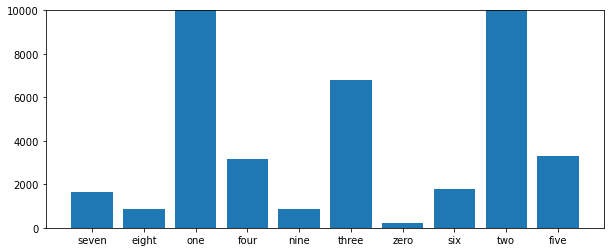

In [89]:
labels = [k for k in keywords_set]
counts = [usable[k].value_counts().loc[True] for k in keywords_set]
fig, ax = plt.subplots()
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
fig.patch.set_facecolor('white')
ax.set_ylim(0,10000)
ax.bar(range(len(labels)), counts);
fig.set_size_inches(10,4)

In [43]:
usable["öffne"].value_counts()

False    59205
True        15
Name: öffne, dtype: int64

In [44]:
# write to tsv
usable.drop(columns=["keywords"], axis=1).to_csv(
    "keywords_listen.tsv", sep="\t", quoting=csv.QUOTE_MINIMAL, index=False
)

In [ ]:
b = os.path.getsize("keywords_listen.tsv")

In [ ]:
b / 1024 ** 2 #MB

In [45]:
#keywords = pd.read_csv("keywords_listen.tsv", sep="\t")
keywords = pd.read_csv("keywords_listen_german.tsv", sep="\t")
print(keywords.shape[0])

59220


In [46]:
# select examples each from keywords where the column ["keywords"] == True
NUM_SAMPLES = 2000
samples = {}
for k in keywords_set:
    if keywords[k].value_counts().loc[True] > NUM_SAMPLES:
        #are there more than NUM_SAMPLES examples?
        samples[k] = keywords[keywords[k]].sample(n=NUM_SAMPLES)
    else:
        # use them all
        samples[k] = keywords[keywords[k]]
        logging.warning(f"for keyword {k}, there are not enough examples to sample")
    print("Keyword", k, ":", samples[k].shape[0])    

Keyword links : 285
Keyword drei : 2000
Keyword halt : 657
Keyword nein : 1559
Keyword aus : 2000
Keyword hinunter : 49
Keyword ja : 2000
Keyword öffne : 15
Keyword geh : 147
Keyword richtig : 974
Keyword auf : 2000


In [48]:
q = samples["öffne"]
sample = np.random.randint(q.shape[0])
print(q.iloc[sample].sentence, q.iloc[sample].path)
listen_to_sample(df=q, ix=sample, clips_path=clips_path)

Öffne den Webbrowser und rufe www.archlinux.org auf. common_voice_de_18556969.mp3


In [52]:
q = samples["no"]
sample = np.random.randint(q.shape[0])
print(q.iloc[sample].sentence)

There is no help for it.


In [49]:
parent_dir = "eleven_word_dataset_de"

In [ ]:
# create directory structure
raise ValueError("caution: script operates on fs")
cur = os.getcwd()
print(f"operating in {cur}")
for dest in ["clips"]: # , "extractions_gcloud", "extractions_deepspeech", "transcripts_gcloud"]:
    for k in keywords_set:
        newdir = f"{parent_dir}/{dest}/{k}/"
        os.makedirs(newdir)
        print(newdir)
#os.makedirs(f"{parent_dir}/logs/")

In [55]:
# save tsvs of NUM_SAMPLES examples selected for each of the keywords
for name, df in samples.items():
    # remove all the keywords-present columns
    df.drop(columns=keywords_set, axis=1).to_csv(
        f"{parent_dir}/{name}.tsv", sep="\t", quoting=csv.QUOTE_MINIMAL, index=False
    )

In [57]:
# copy source mp3s into correct subdirectory
for keyword, df in samples.items():
    for _,r in df.iterrows():
        mp3_path = clips_path + r.path
        
        # copy mp3 as-is
        # shutil.copy2(mp3_path, f"./{parent_dir}/clips/{keyword}")
        
        # copy wav file
        filename_noext = os.path.basename(os.path.splitext(mp3_path)[0])

        dest = f"./{parent_dir}/clips/{keyword}/{filename_noext}.wav"

        transformer = sox.Transformer()
        transformer.convert(samplerate=16000)  # from 48K mp3s
        transformer.build(mp3_path, dest)

        # write out transcription
        utterance = r.sentence
        transcription = f"./{parent_dir}/clips/{keyword}/{filename_noext}.txt"
        
        with open(transcription, 'w') as fh:
            fh.write(utterance)

In [63]:
# calculate total length of all samples
total_time = 0
for keyword, _ in samples.items():
    #clips = glob.glob(f"./{parent_dir}/clips/{keyword}/*.mp3")
    clips = glob.glob(f"./{parent_dir}/clips/{keyword}/*.wav")
    print("keyword", keyword, ":", len(clips), "utterances")
    kw_time = 0
    for c in clips:
        s = sox.file_info.duration(c)
        kw_time += s
    print(f"{kw_time / 60 ** 2:.2f} hours")
    total_time += kw_time
print("TOTAL", f"{total_time / 60 ** 2:.2f} hours")

keyword links : 285 utterances
0.36 hours
keyword drei : 2000 utterances
2.73 hours
keyword halt : 657 utterances
0.70 hours
keyword nein : 1559 utterances
1.33 hours
keyword aus : 2000 utterances
2.92 hours
keyword hinunter : 49 utterances
0.05 hours
keyword ja : 2000 utterances
2.02 hours
keyword öffne : 15 utterances
0.02 hours
keyword geh : 147 utterances
0.14 hours
keyword richtig : 974 utterances
1.29 hours
keyword auf : 2000 utterances
2.88 hours
TOTAL 14.46 hours


## Extract keywords using Google Cloud STT API Results

In [51]:
def find_keyword(timings, keyword):
    """returns either (start,end) in seconds, or None"""
    for timing in timings:
        word = timing['word']
        
        # TODO(MMAZ) note this only extracts the first word for now
        # i.e., "tap up, then up, then down" will only return the first "up"
        if word == keyword:
            return timing['start_time'], timing['end_time']
    return None

count number of found words via GCloud STT

In [ ]:
kws = ["up","down","left","right","stop","go","off","on","yes","no","three"]
missing = {w:0 for w in kws}
found = {w:0 for w in kws}
for keyword in kws:
    #df = pd.read_csv(f"./eleven_word_dataset/{keyword}.tsv", sep="\t")
    transcripts = glob.glob(f"eleven_word_dataset/transcripts_gcloud/{keyword}/*.json")
    for fname in transcripts:
        with open(fname, 'r') as fh:
            try:
                transcription = json.load(fh)
            except json.JSONDecodeError as e:
                #logging.warning(f"no transcription returned by GCP STT API for sentence {ix}")
                missing[keyword] += 1
                continue
        result = find_keyword(transcription["timings"], keyword)
        if result is None:
            missing[keyword] += 1
        else:
            found[keyword] += 1
    
#     for ix, r in df.iterrows():
#         fname = f"./eleven_word_dataset/transcripts_gcloud/{keyword}/{r.path}.json"
#         if not os.path.exists(fname):
#             missing[keyword] += 1
#             print(fname)
#             break
print("missing", missing)
print("found", found)

In [50]:
def extract_one_second(duration_s: float, start_s: float, end_s: float):
    """
    return one second around the midpoint between start_s and end_s
    """
    if duration_s < 1:
        return (0, duration_s)

    center_s = start_s + ((end_s - start_s) / 2.0)

    new_start_s = center_s - 0.5
    new_end_s = center_s + 0.5

    if new_end_s > duration_s:
        new_end_s = duration_s
        new_start_s = duration_s - 1.0

    if new_start_s < 0:
        new_start_s = 0
        new_end_s = np.minimum(duration_s, new_start_s + 1.0)

#     print(
#         "start",
#         new_start_s,
#         "end",
#         new_end_s,
#         "\nduration",
#         new_end_s - new_start_s,
#         "midpoint",
#         new_start_s + ((new_end_s - new_start_s) / 2.0),
#     )
    return (new_start_s, new_end_s)

In [ ]:
parent_dir = "eleven_word_dataset"

log_location = f"{parent_dir}/logs/gcloud.log"
logging.basicConfig(
    level=logging.INFO, 
    format='[%(asctime)s ::: %(levelname)s] %(message)s',
    handlers=[
        logging.FileHandler(filename=log_location),
        logging.StreamHandler(sys.stdout)
    ]
)

Example parameters for `speech_commands`

```bash
soxi speech_commands/stop/234d6a48_nohash_2.wav

Input File     : 'speech_commands/stop/234d6a48_nohash_2.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:01.00 = 16000 samples ~ 75 CDDA sectors
File Size      : 32.0k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM

```

For `common voice`:

```bash
soxi mozilla_common_voice/clips/common_voice_en_19293740.mp3

Input File     : 'mozilla_common_voice/clips/common_voice_en_19293740.mp3'
Channels       : 1
Sample Rate    : 48000
Precision      : 16-bit
Duration       : 00:00:04.82 = 231552 samples ~ 361.8 CDDA sectors
File Size      : 38.6k
Bit Rate       : 64.1k
Sample Encoding: MPEG audio (layer I, II or III)
```


In [ ]:
dataset = "eleven_word_dataset"
kws = ["up", "down", "left", "right", "stop", "go", "off", "on", "yes", "no", "three"]
missing = {kw:0 for kw in kws}
for keyword in kws:
    # df = pd.read_csv(f"./eleven_word_dataset/{keyword}.tsv", sep="\t")
    transcripts = glob.glob(f"{dataset}/transcripts_gcloud/{keyword}/*.json")
    for ix, fname in enumerate(transcripts):

        # keep track of current keyword in separate file
        if ix % 100 == 0:
            with open("./tmp/current_gcloud.txt", "a") as fh:
                fh.write(f"{keyword} {ix}\n")

        with open(fname, "r") as fh:
            try:
                transcription = json.load(fh)
            except json.JSONDecodeError as e:
                # logging.warning(
                #     f"no transcription returned by GCP STT API for sentence {ix}")
                missing[keyword] += 1
                continue
        result = find_keyword(transcription["timings"], keyword)
        if result is None:
            logging.warning(
                f"keyword {keyword} not found in inference for sentence {ix}:\n"
                f" - {transcription['transcript']}"
            )
            continue
        start_s, end_s = result
        if end_s - start_s > 1:
            logging.warning(
                f"{keyword} clip ix: {ix} timestamps are longer than one second"
            )

        mp3_fn = os.path.split(fname)[-1][:-5]  # elide .json from the filename
        mp3_path = f"{dataset}/clips/{keyword}/{mp3_fn}"

        duration = sox.file_info.duration(mp3_path)
        if duration < 1:
            logging.warning(f"{keyword} clip ix {ix} shorter than 1s")

        dest = f"./{dataset}/extractions_gcloud/{keyword}/{mp3_path}.wav"

        start_s, end_s = extract_one_second(duration, start_s, end_s)

        # to listen:
        # clip = pydub.AudioSegment.from_wav()
        # play(clip)
        # extraction = clip[start_s * 1000:end_s * 1000]
        # play(extraction)

        transformer = sox.Transformer()
        transformer.convert(samplerate=16000)  # from 48K mp3s
        transformer.trim(start_s, end_s)
        transformer.fade(fade_in_len=0.1, fade_out_len=0.1)
        dest = f"./{dataset}/extractions_gcloud/{keyword}/{mp3_fn}.wav"
        transformer.build(mp3_path, dest)
        # run 'soxi' on the output wav to inspect encoding parameters

        # listen to the processed audio:
        # play(pydub.AudioSegment.from_wav(dest))

In [ ]:
keyword = "three"
df = pd.read_csv(f"./micro_dataset/{keyword}.tsv", sep="\t")
print(f"{keyword}.tsv # of examples:", df.shape[0])

for ix, (_, r) in enumerate(df.iterrows()):
    if ix != 30:
        continue
    if ix % 10 == 0:
        print("progress", ix)
    mp3_path = f"./micro_dataset/clips/{keyword}/" + r.path
    
    fname = f"./micro_dataset/transcripts_googlecloud/{keyword}/{r.path}.json"
    with open(fname, 'r') as fh:
        try:
            transcription = json.load(fh)
        except json.JSONDecodeError as e:
            logging.warning(f"no transcription returned by GCP STT API for sentence {ix}")
            continue

    result = find_keyword(transcription["timings"], keyword)
    if result is None:
        logging.warning(f"keyword {keyword} not found in inference for sentence {ix}:\n - {transcription['transcript']}")
        continue

    start_s, end_s = result    
    
    dest = f"./micro_dataset/extractions_googlecloud/{keyword}/{r.path}.wav"
    
    # convert to wav (will overwrite existing dest)
    transformer = sox.Transformer()
    transformer.convert(samplerate=16000)
    transformer.trim(start_s, end_s)
    transformer.build(mp3_path, dest)
    
    # to listen
    clip = pydub.AudioSegment.from_wav(dest)
    play(clip)

### Listen to word splits

In [ ]:
selected = pd.read_csv("selected_clips_yes_no_three.tsv", sep="\t")

In [ ]:
# TODO(MMAZ) lower() and remove punctuation, etc
# pasted from https://stackoverflow.com/a/32558749
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [ ]:
def listen_to_split_on_boundaries(timings, clip, keywords_set=None):
    if keywords_set is not None:
        words = set([t["word"] for t in timings])
        if words.isdisjoint(keywords_set):
            print("No keywords found in the transcription")
    for ix, timing in enumerate(timings):
        word = timing['word']
        if keywords_set and word not in keywords_set:
            continue
        start_ms = timing['start_time'] * 1000
        end_ms = timing['end_time'] * 1000
        print(f"word {ix}: {word} \n - start_time: {timing['start_time']:.3f} - end_time: {timing['end_time']:.3f}")
        play(clip[start_ms:end_ms])
        time.sleep(1)

### Selected keywords

In [ ]:
keyword_set

In [ ]:
for ix, row in selected.iterrows():
    print(f"Sample: {ix}")
    fname = "./keywords_transcriptions/" + row.path + ".json"
    with open(fname, 'r') as fh:
        transcription = json.load(fh)
    gt = row.sentence
    print(f"Groundtruth: {gt}")
    text = transcription['transcript']
    print(f"Inference: {text}")
    print("Edit Distance:", levenshteinDistance(gt, text))
    print("\n--\n")
    clip = listen_to_sample(df=selected, ix=ix, clips_path=clips_path)
    listen_to_split_on_boundaries(transcription['timings'], clip, keywords_set=keyword_set)
    time.sleep(4)
    clear_output()

## CommonVoice Speech Commands

https://voice.mozilla.org/en/datasets

Single-word target segments

In [90]:
#val_path = "../commonvoice_singleword/cv-corpus-5-singleword/en/validated.tsv"
val_path = "../commonvoice_singleword/cv-corpus-5-singleword/de/validated.tsv"
val_df = pd.read_csv(val_path, sep='\t')
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12191 entries, 0 to 12190
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   client_id   12191 non-null  object
 1   path        12191 non-null  object
 2   sentence    11319 non-null  object
 3   up_votes    12191 non-null  int64 
 4   down_votes  12191 non-null  int64 
 5   age         4622 non-null   object
 6   gender      4594 non-null   object
 7   accent      3635 non-null   object
 8   locale      12191 non-null  object
 9   segment     12191 non-null  object
dtypes: int64(2), object(8)
memory usage: 952.5+ KB


In [92]:
# NaN values?
val_df[val_df.sentence.isna()].shape[0]
# caution! in german, 'nan' is being used for zero apparently -- NOT really a NaN!
# val_df.dropna(subset=['sentence'],inplace=True)

872

In [93]:
words = set([w for w in val_df.sentence])
words

{'Firefox',
 'Hei',
 'acht',
 'drei',
 'eins',
 'fünf',
 'ja',
 nan,
 'nein',
 'neun',
 'sechs',
 'sieben',
 'vier',
 'zwei'}

In [94]:
wordcounts = {}
for w in words:
    word_df = val_df[val_df.sentence == w]
    wordcounts[w] = word_df.shape[0]
wordcounts

{'vier': 886,
 nan: 0,
 'zwei': 896,
 'drei': 887,
 'neun': 891,
 'acht': 910,
 'nein': 887,
 'Hei': 632,
 'sieben': 879,
 'sechs': 873,
 'ja': 922,
 'eins': 884,
 'fünf': 889,
 'Firefox': 883}

In [8]:
val_df.iloc[65]

client_id     6b9ee6a8405cdb1c7404bb6376d18022eee4823c012616...
path                               common_voice_en_22074788.mp3
sentence                                                Firefox
up_votes                                                      2
down_votes                                                    1
age                                                         NaN
gender                                                      NaN
accent                                                      NaN
locale                                                       en
segment                                    Singleword Benchmark
Name: 65, dtype: object

In [9]:
row = val_df.iloc[65]

In [54]:
transformer = sox.Transformer()
transformer.convert(samplerate=16000)  # from 48K mp3s
mp3_path = clips + row.path
dest = f"{dsdir}/{row.sentence.lower()}/{row.path}.wav"
print(mp3_path, "\n",dest)
transformer.build(mp3_path, dest)
# run 'soxi' on the output wav to inspect encoding parameters

output_file: ../singleword_train/firefox/common_voice_en_22074788.mp3.wav already exists and will be overwritten on build


../commonvoice_singleword/cv-corpus-5-singleword/en/clips/common_voice_en_22074788.mp3 
 ../singleword_train/firefox/common_voice_en_22074788.mp3.wav


True

Row 65:

`singleword_train/firefox/common_voice_en_22074788.mp3.wav`

Contains `firefox` said twice

6 seconds long 

```
soxi ../singleword_train/firefox/common_voice_en_22074788.mp3.wav

Input File     : '../singleword_train/firefox/common_voice_en_22074788.mp3.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:06.31 = 100992 samples ~ 473.4 CDDA sectors
File Size      : 202k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM
```


In [15]:
#f = pydub.AudioSegment.from_wav("../singleword_train/firefox/common_voice_en_22074788.mp3.wav")
f = pydub.AudioSegment.from_wav("../commonvoice_singleword/en_wav_ext/common_voice_en_22074788.mp3.wav")
play(f)

Running `extract_loudest_section` results in `<mic noises> firefo-` on the above example

In [18]:
dest_dir = "../singleword_train"

In [20]:
# after running extract_loudest_section, organize files into directories
raise ValueError("copies a large number of files")

clips_dir = "../commonvoice_singleword/en_wav_ext"
missing = 0
for ix,r in val_df.iterrows():
    mp3_name = r.path
    target_word = r.sentence.lower()
    wav_file = f"{clips_dir}/{mp3_name}.wav"
    if not os.path.exists(wav_file):
        missing += 1
        continue
    target = f"{dest_dir}/{target_word}/"
    shutil.copy2(wav_file, target)
print("Missing", missing)

Missing 725


725 missing files between `validated.txt`, `sox` wav conversion (some failed), and after running `extract_loudest_section`

In [22]:
for w in words:
    d = os.listdir(f"{dest_dir}/{w.lower()}/")
    print(w, len(d))

seven 1867
eight 1729
zero 1818
four 1769
one 1855
nine 1894
three 1620
no 1835
yes 1923
Firefox 1846
five 1785
Hey 1833
six 1832
two 1739


hacking together a quasi ROC (TPR vs FPR, not precision/recall or sensitivity/specificity)

5 word dataset (out of 11)

200 Ground Truth words

* 0.0
  * 98.5% matched, 29.0% correct, 251.0% wrong, 6.0% false positive, 0.0% false negative
* 0.1
  * 98.5% matched, 29.0% correct, 251.0% wrong, 6.0% false positive, 0.0% false negative
* 0.2
  * 98.5% matched, 28.0% correct, 251.0% wrong, 6.0% false positive, 0.0% false negative
* 0.3
  * 97.5% matched, 32.0% correct, 208.5% wrong, 4.5% false positive, 1.5% false negative
* 0.4
  * 89.0% matched, 35.0% correct, 124.5% wrong, 0.0% false positive, 8.0% false negative
* 0.5
  * 89.0% matched, 35.0% correct, 124.5% wrong, 0.0% false positive, 8.0% false negative
* 0.6
  *  41.5% matched, 26.5% correct, 20.0% wrong, 0.0% false positive, 56.5% false negative
* 0.7
  * 19.0% matched, 14.0% correct, 5.5% wrong, 0.0% false positive, 80.0% false negative
* 0.8
  * 7.0% matched, 6.5% correct, 0.5% wrong, 0.0% false positive, 92.5% false negative
* 0.9
  * 1.5% matched, 1.5% correct, 0.0% wrong, 0.0% false positive, 98.5% false negative
* 1.0
  * 0.0% matched, 0.0% correct, 0.0% wrong, 0.0% false positive, 100.0% false negative


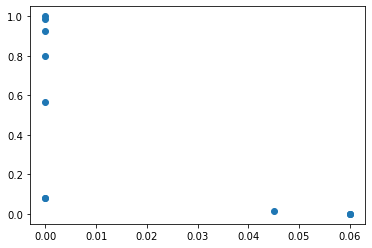

In [7]:
fp = [.06, .06, .06, .045, 0., 0., 0., 0., 0., 0., 0.]
tp = [0., 0., 0., .015, .08, .08, .565, .8, .925, .985, 1.]
plt.scatter(fp,tp);